## PROYECTO ANÁLISIS DE DEPRESIÓN PRINCIPALMENTE DE ESTUDIANTES EN INDIA

### FUENTE:
Tomando de Kaggle. URL: URL: https://www.kaggle.com/datasets/hopesb/student-depression-dataset

### METODOLOGÍA: 
Explicar la variable dicotómica de depresión (0:no, 1:sí). A partir de variables continuas y categóricas. Revisando supuestos para aplicar regresión lógistica y estadística bayesiana.  

In [1]:
## Importación librerias

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from scipy.stats import pointbiserialr, chi2_contingency
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import pymc as pm
import arviz as az


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
## Lectura de datos 
datos = pd.read_csv(r"C:\Users\LENOVO\Desktop\Repositorio Github\Proyectos-Python\Proyecto_Depresion\Student Depression Dataset.csv")

# Ver las primeras filas
print(datos.head())
# Ver la estructura general: número de filas y columnas
print(datos.shape)
# Ver el tipo de datos por columna
print(datos.dtypes)
# Ver nombres de columnas
print(datos.columns)


   id  Gender   Age           City Profession  Academic Pressure  \
0   2    Male  33.0  Visakhapatnam    Student                5.0   
1   8  Female  24.0      Bangalore    Student                2.0   
2  26    Male  31.0       Srinagar    Student                3.0   
3  30  Female  28.0       Varanasi    Student                3.0   
4  32  Female  25.0         Jaipur    Student                4.0   

   Work Pressure  CGPA  Study Satisfaction  Job Satisfaction  \
0            0.0  8.97                 2.0               0.0   
1            0.0  5.90                 5.0               0.0   
2            0.0  7.03                 5.0               0.0   
3            0.0  5.59                 2.0               0.0   
4            0.0  8.13                 3.0               0.0   

      Sleep Duration Dietary Habits   Degree  \
0          5-6 hours        Healthy  B.Pharm   
1          5-6 hours       Moderate      BSc   
2  Less than 5 hours        Healthy       BA   
3          7-8

In [3]:
### Filtrado y manipulación tipo de datos

## Eliminar columnas no útiles para modelado
datos.drop(columns=["id"], inplace=True)

## Cambio tipo de datos - Mantuve númericas las que estaban bien y puse categóricas las que deben serlo
cols_a_categorizar = ['Gender', 'City', 'Profession', 'Academic Pressure',
                      'Work Pressure', 'Study Satisfaction', 'Job Satisfaction',
                      'Sleep Duration', 'Dietary Habits', 'Degree',
                      'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
                      'Financial Stress', 'Family History of Mental Illness', 'Depression']

datos[cols_a_categorizar] = datos[cols_a_categorizar].astype('category')

print("Verificación eliminación y cambio tipo de columnas de datos")
print(datos.dtypes)

## Verificación de no duplicidad en filas o columnas
filas_duplicadas = datos.duplicated()
columnas_duplicadas = datos.T.duplicated()
# Mostrar cuántas hay
print("\n")
print(f"Filas duplicadas: {filas_duplicadas.sum()}")
print(f"Filas duplicadas: {datos.columns[columnas_duplicadas]}")

## Revisar nulos
print("\n--- Valores nulos por columna ---")
print(datos.isnull().sum())


Verificación eliminación y cambio tipo de columnas de datos
Gender                                   category
Age                                       float64
City                                     category
Profession                               category
Academic Pressure                        category
Work Pressure                            category
CGPA                                      float64
Study Satisfaction                       category
Job Satisfaction                         category
Sleep Duration                           category
Dietary Habits                           category
Degree                                   category
Have you ever had suicidal thoughts ?    category
Work/Study Hours                         category
Financial Stress                         category
Family History of Mental Illness         category
Depression                               category
dtype: object


Filas duplicadas: 0
Filas duplicadas: Index([], dtype='object')

--- Valor

Ya que se cuenta con el dataframe sin datos duplicados, con el tipo de columnas requeridas y muy pocos valores nuelos. Se procede a hacer un análisis de los datos que hay en cada columna. Para ver si existe cierto sesgo hacia alguna categoría. Para ello:
* Se usarán **gráficos**. 
    * Gráficos de barras para las variables categóricas
    * Histogramas para las variables continuas**. 
* Se hará un primer análisis de **influencia** entre la variable de depresión contra las demás variables. Para ello:
    * Si la variable a analizar es numérica, se usará correlación point-biserial. 
    * Si la variable es categórica, se usará Cramér’s V (para más de 2 categorías) o también point-biserial si es binaria.

 

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16168\2328847991.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=datos, x=col, ax=ax, order=order, palette='pastel')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16168\2328847991.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=datos, x=col, ax=ax, order=order, palette='pastel')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16168\2328847991.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=datos, x=col, ax=ax, order=order, palette='pastel')
C:\Users\LENOVO\AppData\L

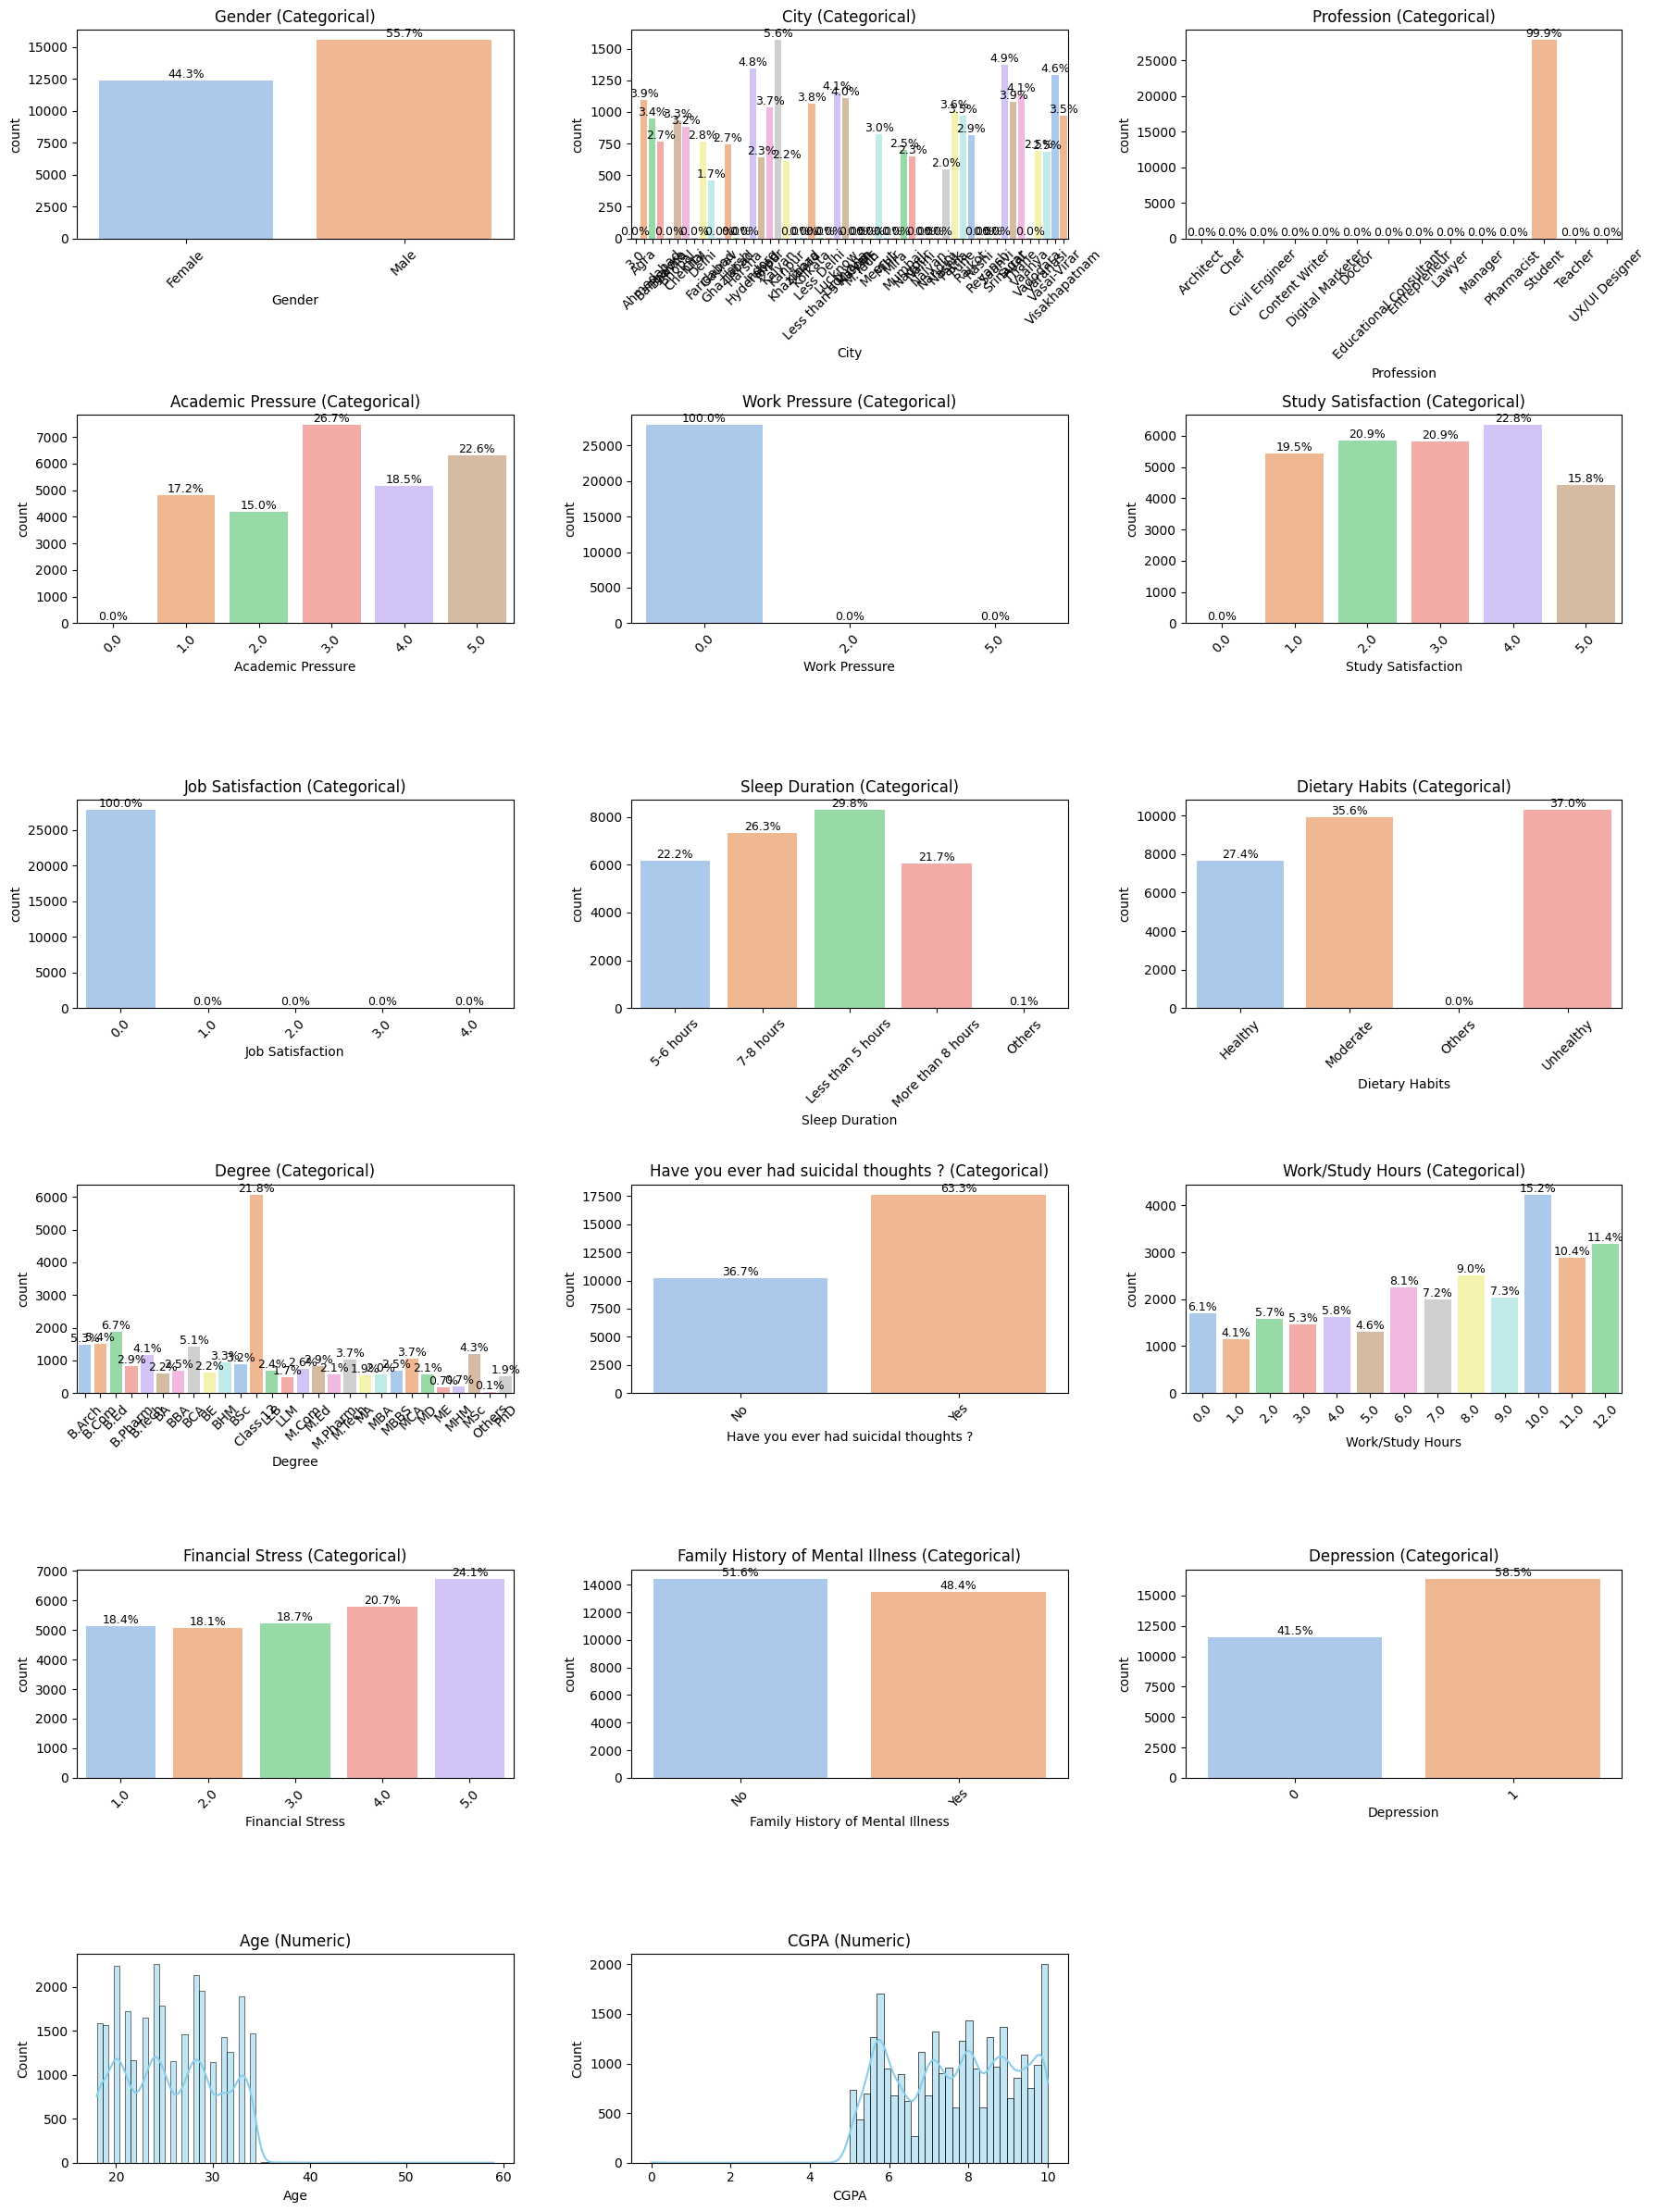

In [4]:
# --- Separar columnas por tipo ---
cat_cols = datos.select_dtypes(include='category').columns
num_cols = datos.select_dtypes(include='number').columns

# --- Total de columnas ---
total_cols = len(cat_cols) + len(num_cols)

# --- Tamaño de figura ---
cols = 3  # columnas por fila
rows = math.ceil(total_cols / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

# --- Gráficos para categóricas ---
for i, col in enumerate(cat_cols):
    ax = axes[i]
    order = datos[col].cat.categories
    total = len(datos[col])

    # Crear gráfico
    sns.countplot(data=datos, x=col, ax=ax, order=order, palette='pastel')

    # Añadir porcentaje encima de las barras
    for p in ax.patches:
        count = int(p.get_height())
        percentage = 100 * count / total
        ax.annotate(f'{percentage:.1f}%', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=9)

    ax.set_title(f"{col} (Categorical)")
    ax.tick_params(axis='x', rotation=45)

# --- Gráficos para numéricas ---
offset = len(cat_cols)
for j, col in enumerate(num_cols):
    ax = axes[offset + j]
    sns.histplot(data=datos, x=col, kde=True, ax=ax, color='skyblue')
    ax.set_title(f"{col} (Numeric)")

# --- Eliminar subplots vacíos ---
for k in range(total_cols, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()

In [5]:
## Tal como se muestra, los datos de Work satisfactio y Job pressure, toman siempre valor de 0. Posiblemente debido a que la mayoría son estudiantes, por tal razón, se procede a eliminar las 3 columnas del dataframe. 
ciudades_agrupadas = datos["City"].value_counts()
ciudades_comunes = ciudades_agrupadas[ciudades_agrupadas >= 50].index
datos["City"] = datos["City"].apply(lambda x: x if x in ciudades_comunes else "Other") # Se realiza la unión de ciudades con pocas personas, para evitar que haya un gran peso mentira en la variable ciudades

datos.drop(columns=["Profession", "Work Pressure", "Job Satisfaction"], inplace=True)

                                       Correlation with Depression  \
Have you ever had suicidal thoughts ?                        0.546   
Academic Pressure                                            0.480   
Financial Stress                                             0.364   
Work/Study Hours                                             0.215   
Dietary Habits                                               0.208   
Study Satisfaction                                           0.169   
Degree                                                       0.138   
Sleep Duration                                               0.100   
Family History of Mental Illness                             0.053   
CGPA                                                         0.022   
Gender                                                       0.002   
Age                                                         -0.226   

                                             p-value  Significant  
Have you ever had sui

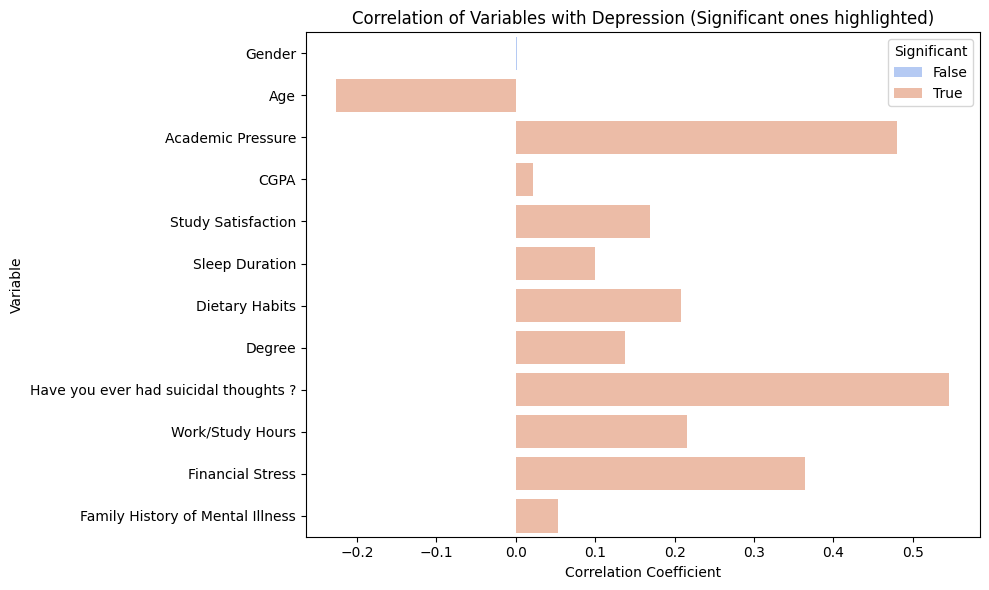

In [6]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, p_value, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1)), p_value


# --- Resultados ---
resultados = {}
p_values = {}

for col in datos.columns:
    if col == 'Depression':
        continue
    if datos[col].dtype in ['float64', 'int64']:
        # Correlación numérica con binaria (Point-Biserial)
        coef, p_value = pointbiserialr(datos['Depression'], datos[col])
        resultados[col] = round(coef, 3)
        p_values[col] = p_value
    elif datos[col].dtype.name == 'category':
        # Correlación categórica con binaria (Cramér's V)
        coef, p_value = cramers_v(datos[col], datos['Depression'])
        resultados[col] = round(coef, 3)
        p_values[col] = p_value

# Convertir a DataFrame para visualización
res_df = pd.DataFrame.from_dict(resultados, orient='index', columns=['Correlation with Depression'])
p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p-value'])

# Unir ambas tablas
final_df = pd.concat([res_df, p_values_df], axis=1)

# Filtrar los que son estadísticamente significativos (p < 0.05)
final_df['Significant'] = final_df['p-value'] < 0.05

# Mostrar resultados
print(final_df.sort_values(by='Correlation with Depression', ascending=False))

# (Opcional) Visualización de correlaciones significativas
plt.figure(figsize=(10, 6))
sns.barplot(x=final_df['Correlation with Depression'], y=final_df.index, hue=final_df['Significant'], palette='coolwarm')
plt.title("Correlation of Variables with Depression (Significant ones highlighted)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


En resumen, hay variables que sólo tomaban 1 valor posible, por lo cual, se eliminan. En adición, se realiza un análisi entre la variable depresión y las demás variables utilizando el coeficiente según su tipo, donde, también se realizó un análisis de significacia estadística tomando un valor p del 5%, con esto, se encontró que la variable género no tiene una alta importancia en si la persona sufre depresión o no. Sin embargo, parece que lo que más se relaciona es el hecho de tener presión acádemica y pensamientos suicidas. 

### Revisión supuestos para regresión logaritmica, dado que se cuenta con una variable respuesta (depression) con valores de 0 (no) o 1(sí).

In [7]:
# Primero, se realiza One-hot encoding
datos_encoded = pd.get_dummies(datos.drop(columns=["Depression"]), drop_first=True)
# Separar X e y
X = datos_encoded
y = datos["Depression"]

# Se revisa el VIF, para verificar que la información de una columna no esté muy relacionada a otra columna y entreguen dos variables la misma info en la variable respuesta
print("\n--- VIF (Multicolinealidad) ---")
X_scaled = StandardScaler().fit_transform(X)
X_vif = pd.DataFrame(X_scaled, columns=X.columns)

vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
print(vif_df.sort_values(by="VIF", ascending=False))


--- VIF (Multicolinealidad) ---
                                Variable          VIF
35                 Academic Pressure_3.0  1337.547509
37                 Academic Pressure_5.0  1192.468000
41                Study Satisfaction_4.0  1083.300110
36                 Academic Pressure_4.0  1028.286342
39                Study Satisfaction_2.0  1018.432956
..                                   ...          ...
75                         Degree_Others     1.025663
22                            City_Other     1.025172
94  Family History of Mental Illness_Yes     1.007268
46                 Sleep Duration_Others     1.006343
48                 Dietary Habits_Others     1.004442

[95 rows x 2 columns]


In [8]:
# Agrupación por variable original (antes del '_')
vif_df["Grupo"] = vif_df["Variable"].str.extract(r"^([^_]+)_")  # extrae lo antes del primer _
vif_df["Grupo"] = vif_df["Grupo"].fillna(vif_df["Variable"])   # por si hay columnas sin "_"

# Resumen por grupo
vif_summary = vif_df.groupby("Grupo").agg(
    n_variables=("Variable", "count"),
    VIF_min = ("VIF", "min"),
    VIF_mean=("VIF", "mean"),
    VIF_max=("VIF", "max")
).reset_index().sort_values(by="VIF_max", ascending=False)

print("\n--- Resumen por variable original ---")
print(vif_summary)


--- Resumen por variable original ---
                                    Grupo  n_variables     VIF_min  \
0                       Academic Pressure            5  869.664839   
11                     Study Satisfaction            5  821.221566   
4                                  Degree           27    1.025663   
12                       Work/Study Hours           12    1.615300   
3                                    City           30    1.025172   
7                        Financial Stress            4    1.647322   
1                                     Age            1    1.771020   
10                         Sleep Duration            4    1.006343   
5                          Dietary Habits            3    1.004442   
9   Have you ever had suicidal thoughts ?            1    1.151454   
8                                  Gender            1    1.032769   
2                                    CGPA            1    1.029699   
6        Family History of Mental Illness          

Tomando en cuenta que los valores VIF debajo de 5, son aceptables. Solamente hay 3 variables que parecen tener información repetida ('City', 'Academic Pressure', 'Study Satisfaction'), se revisa la relación que hay entre esas variables en adición a Depression. 

In [9]:
# Supongamos que tus variables están en un DataFrame llamado df
categorical_vars = ['City', 'Academic Pressure', 'Study Satisfaction', 'Depression']

# Matriz de Cramér's V
cramer_matrix = pd.DataFrame(index=categorical_vars, columns=categorical_vars)

for var1 in categorical_vars:
    for var2 in categorical_vars:
        if var1 == var2:
            cramer_matrix.loc[var1, var2] = 1.0
        else:
            cramer_matrix.loc[var1, var2] = cramers_v(datos[var1], datos[var2])[0]

print("\n--- Cramér's V entre variables categóricas ---")
print(cramer_matrix)



--- Cramér's V entre variables categóricas ---
                        City Academic Pressure Study Satisfaction Depression
City                     1.0          0.063642           0.051344   0.077112
Academic Pressure   0.063642               1.0           0.338057   0.479957
Study Satisfaction  0.051344          0.338057                1.0   0.168681
Depression          0.077112          0.479957           0.168681        1.0



--- Relación lineal log-odds (visualización) ---


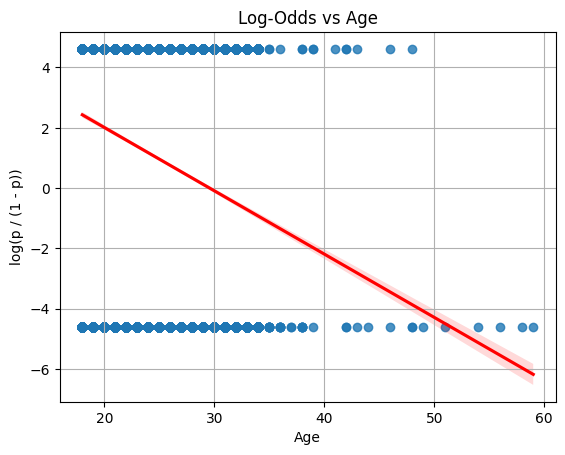

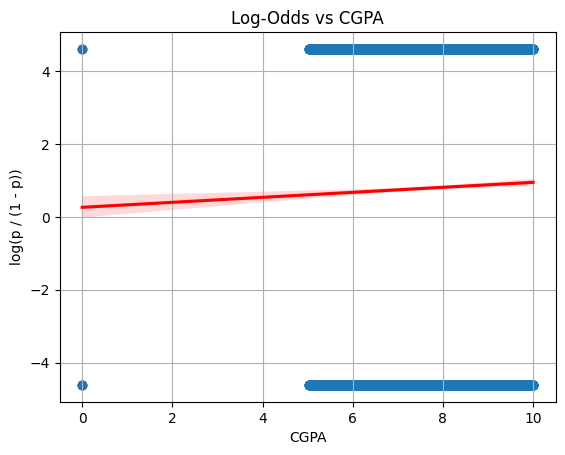

In [10]:
y = datos["Depression"].astype(int)  # aseguramos que es entero

print("\n--- Relación lineal log-odds (visualización) ---")
for col in X.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure()
    sns.regplot(x=X[col], y=np.log((y + 0.01) / (1 - y + 0.01)), line_kws={'color': 'red'})
    plt.title(f'Log-Odds vs {col}')
    plt.xlabel(col)
    plt.ylabel('log(p / (1 - p))')
    plt.grid(True)
    plt.show()

Parece que la variable de Age, tiene una inversa a medida que se tiene más edad. Por el contrario, la variable de CGPA parece tener una relación directa con la depresión, sin embargo, parece ser poca. A continuación se realiza un ajuste del modelo para ir revisando la influencia de las variables en la depresión de los estudiantes analizados en India.  

Optimization terminated successfully.
         Current function value: 0.345997
         Iterations 7

--- Resumen del modelo ---
                           Logit Regression Results                           
Dep. Variable:             Depression   No. Observations:                27901
Model:                          Logit   Df Residuals:                    27805
Method:                           MLE   Df Model:                           95
Date:                Tue, 22 Apr 2025   Pseudo R-squ.:                  0.4900
Time:                        15:06:27   Log-Likelihood:                -9653.7
converged:                       True   LL-Null:                       -18930.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const             

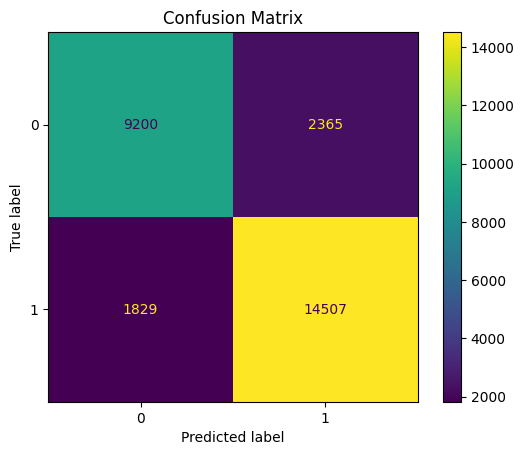

In [11]:
# --- Ajustar modelo con statsmodels para ver coeficientes y outliers ---
X_sm = sm.add_constant(X)  # Agregar intercepto
for col in X_sm.columns:
    try:
        X_sm[col] = X_sm[col].astype(float)
    except ValueError:
        print(f"No se pudo convertir {col}")

modelo = sm.Logit(y, X_sm)
resultado = modelo.fit()

print("\n--- Resumen del modelo ---")
print(resultado.summary())


#confusion matrices for each model
y_pred = resultado.predict(X_sm)
y_pred_clase = (y_pred >= 0.5).astype(int)
cm = confusion_matrix(y, y_pred_clase)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title(f"Confusion Matrix")
plt.show()

Optimization terminated successfully.
         Current function value: 0.347311
         Iterations 7

--- Resumen del modelo ---
                           Logit Regression Results                           
Dep. Variable:             Depression   No. Observations:                27901
Model:                          Logit   Df Residuals:                    27835
Method:                           MLE   Df Model:                           65
Date:                Tue, 22 Apr 2025   Pseudo R-squ.:                  0.4881
Time:                        15:06:29   Log-Likelihood:                -9690.3
converged:                       True   LL-Null:                       -18930.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const             

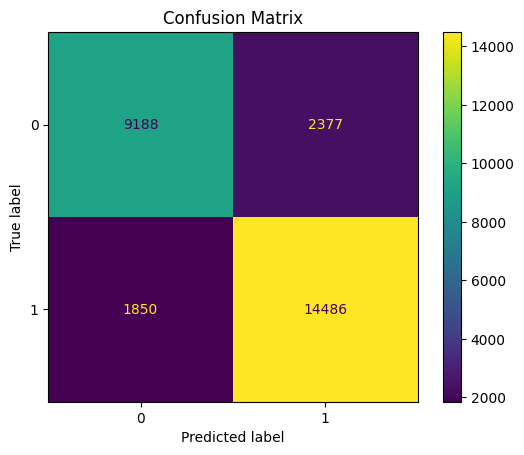

In [12]:
# --- Ajustar modelo con statsmodels para ver coeficientes y outliers ---
X_sm_sincity = X_sm.drop(columns=[col for col in X_sm.columns if "City" in col])
modelo_sincity = sm.Logit(y, X_sm_sincity)
resultado_sincity = modelo_sincity.fit()

print("\n--- Resumen del modelo ---")
print(resultado_sincity.summary())


#confusion matrices for each model
y_pred = resultado_sincity.predict(X_sm_sincity)
y_pred_clase = (y_pred >= 0.5).astype(int)
cm = confusion_matrix(y, y_pred_clase)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title(f"Confusion Matrix")
plt.show()

Optimization terminated successfully.
         Current function value: 0.419414
         Iterations 7

--- Resumen del modelo ---
                           Logit Regression Results                           
Dep. Variable:             Depression   No. Observations:                27901
Model:                          Logit   Df Residuals:                    27840
Method:                           MLE   Df Model:                           60
Date:                Tue, 22 Apr 2025   Pseudo R-squ.:                  0.3818
Time:                        15:06:30   Log-Likelihood:                -11702.
converged:                       True   LL-Null:                       -18930.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const             

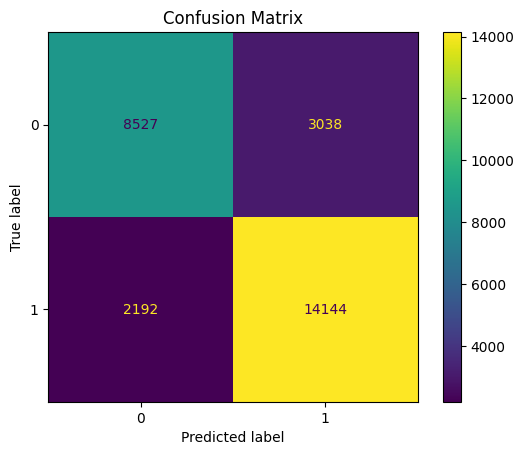

In [13]:
# --- Ajustar modelo con statsmodels para ver coeficientes y outliers ---
X_sm_sincity = X_sm.drop(columns=[col for col in X_sm.columns if "City" in col])
X_sm_sincity_sinacadpres = X_sm_sincity.drop(columns=[col for col in X_sm.columns if "Academic Pressure" in col])

modelo_sincity_sinacadpres = sm.Logit(y, X_sm_sincity_sinacadpres)
resultado_sincity_sinacadpres = modelo_sincity_sinacadpres.fit()

print("\n--- Resumen del modelo ---")
print(resultado_sincity_sinacadpres.summary())


#confusion matrices for each model
y_pred = resultado_sincity_sinacadpres.predict(X_sm_sincity_sinacadpres)
y_pred_clase = (y_pred >= 0.5).astype(int)
cm = confusion_matrix(y, y_pred_clase)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title(f"Confusion Matrix")
plt.show()

Optimization terminated successfully.
         Current function value: 0.353410
         Iterations 7

--- Resumen del modelo ---
                           Logit Regression Results                           
Dep. Variable:             Depression   No. Observations:                27901
Model:                          Logit   Df Residuals:                    27840
Method:                           MLE   Df Model:                           60
Date:                Tue, 22 Apr 2025   Pseudo R-squ.:                  0.4791
Time:                        15:06:32   Log-Likelihood:                -9860.5
converged:                       True   LL-Null:                       -18930.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const             

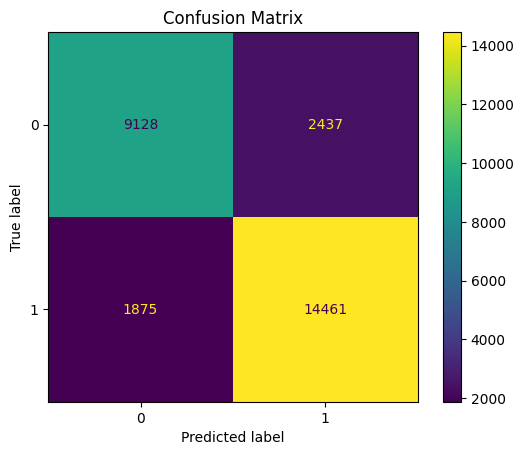

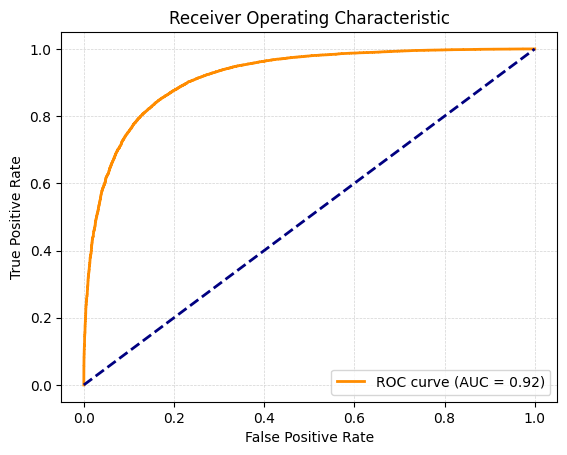

In [14]:
# --- Ajustar modelo con statsmodels para ver coeficientes y outliers ---
X_sm_sincity = X_sm.drop(columns=[col for col in X_sm.columns if "City" in col])
X_sm_sincity_sinstudysatisfaction = X_sm_sincity.drop(columns=[col for col in X_sm.columns if "Study Satisfaction" in col])

modelo_sincity_sinstuadysatisfaction = sm.Logit(y, X_sm_sincity_sinstudysatisfaction)
resultado_sincity_sinstuadysatisfaction = modelo_sincity_sinstuadysatisfaction.fit()

print("\n--- Resumen del modelo ---")
print(resultado_sincity_sinstuadysatisfaction.summary())


#confusion matrices for each model
y_pred = resultado_sincity_sinstuadysatisfaction.predict(X_sm_sincity_sinstudysatisfaction)
y_pred_clase = (y_pred >= 0.5).astype(int)
cm = confusion_matrix(y, y_pred_clase)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title(f"Confusion Matrix")
plt.show()

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = roc_auc_score(y, y_pred)

# Graficar
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea aleatoria
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', linewidth=0.5, color='lightgray')
plt.show()

Optimization terminated successfully.
         Current function value: 0.353411
         Iterations 7

--- Resumen del modelo ---
                           Logit Regression Results                           
Dep. Variable:             Depression   No. Observations:                27901
Model:                          Logit   Df Residuals:                    27841
Method:                           MLE   Df Model:                           59
Date:                Tue, 22 Apr 2025   Pseudo R-squ.:                  0.4791
Time:                        15:06:36   Log-Likelihood:                -9860.5
converged:                       True   LL-Null:                       -18930.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const             

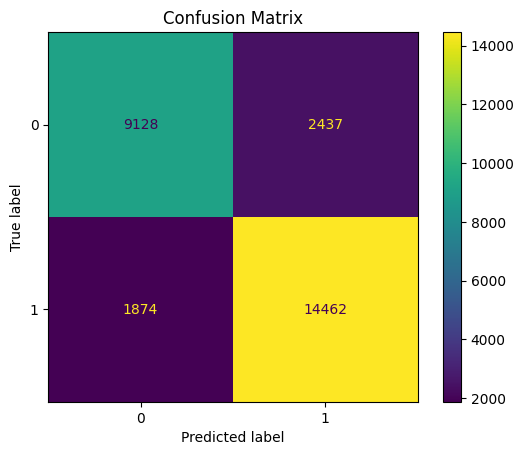

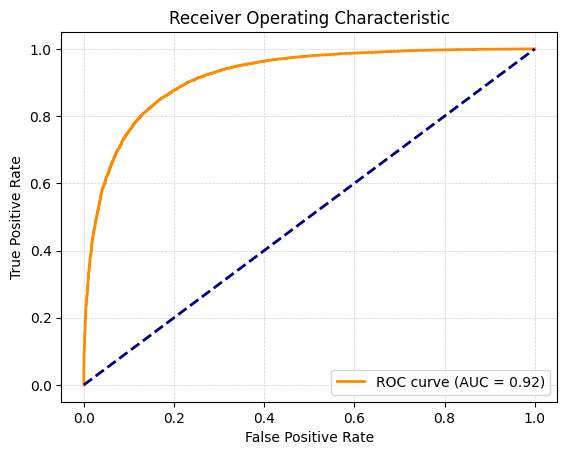

In [15]:
# --- Ajustar modelo con statsmodels para ver coeficientes y outliers ---
X_sm_sincity = X_sm.drop(columns=[col for col in X_sm.columns if "City" in col])
X_sm_sincity_sinstudysatisfaction = X_sm_sincity.drop(columns=[col for col in X_sm.columns if "Study Satisfaction" in col])
X_sm_sincity_sinstudysatisfaction_singender = X_sm_sincity_sinstudysatisfaction.drop(columns=[col for col in X_sm.columns if "Gender" in col])

modelo_sincity_sinstuadysatisfaction_singender = sm.Logit(y, X_sm_sincity_sinstudysatisfaction_singender)
resultado_sincity_sinstuadysatisfaction_singender = modelo_sincity_sinstuadysatisfaction_singender.fit()

print("\n--- Resumen del modelo ---")
print(resultado_sincity_sinstuadysatisfaction_singender.summary())


#confusion matrices for each model
y_pred = resultado_sincity_sinstuadysatisfaction_singender.predict(X_sm_sincity_sinstudysatisfaction_singender)
y_pred_clase = (y_pred >= 0.5).astype(int)
cm = confusion_matrix(y, y_pred_clase)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title(f"Confusion Matrix")
plt.show()

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = roc_auc_score(y, y_pred)

# Graficar
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea aleatoria
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', linewidth=0.5, color='lightgray')
plt.show()

Tomando en cuenta un modelo parsimonioso el modelo final logistico tiene como variables explicativas- Donde además se muestra que tiene un muy buen rendimiento con los estudiantes analizados:

*  Academic Pressure, Sleep Duration, Dietary Habits, Degree, Have you ever had suicidal thoughts?, Work/Study Hours, Financial Stress, Family History of Mental Illness.

Por lo cual, a continuación se analiza el impacto de cada una de las variables. 

In [16]:
# Odds ratios
odds = np.exp(resultado_sincity_sinstuadysatisfaction_singender.params)
odds_df = odds.to_frame(name="Odds Ratio")

# Extraer prefijo (antes del primer "_")
odds_df["Variable Group"] = odds_df.index.to_series().apply(lambda x: x.split("_")[0] if "_" in x else x)

# Agrupar por grupo (usando el promedio)
grouped_table = odds_df.groupby("Variable Group")["Odds Ratio"].mean().sort_values(ascending=False).reset_index()

# Mostrar la tabla
print(grouped_table)

                           Variable Group  Odds Ratio
0   Have you ever had suicidal thoughts ?   12.082408
1                        Financial Stress    4.664710
2                       Academic Pressure    3.750196
3                        Work/Study Hours    2.335837
4                          Dietary Habits    2.286734
5        Family History of Mental Illness    1.270417
6                                    CGPA    1.075066
7                          Sleep Duration    1.024589
8                                  Degree    0.999292
9                                     Age    0.885776
10                                  const    0.145148


### Análisis con regresión lógistica Bayesiana

In [ ]:
from arviz import concat

# --- Preparar los datos ---
# Asegurate de tener tu DataFrame con X (predictoras) e y (Depression) listos
# datos_filtrado = datos.drop(columns=["Depression", "City", "Gender", "Study Satisfaction"])
X_bay = X_sm_sincity_sinstudysatisfaction_singender.copy()
y_bay = y.copy()

total_draws = 50
step_size = total_draws // 10
traces = []

# --- Modelo Bayesiano ---
with pm.Model() as modelo_bayesiano:
    # Priors para los coeficientes (normal centrado en 0)
    coefs = pm.Normal("coefs", mu=0, sigma=1, shape=X_bay.shape[1])
    
    # Prior para el intercepto
    intercepto = pm.Normal("intercepto", mu=0, sigma=1)

    # Probabilidad de éxito en la logística
    logits = intercepto + pm.math.dot(X_bay.values, coefs)
    p = pm.Deterministic("p", pm.math.sigmoid(logits))

    # Variable observada (respuesta)
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

    # Muestreo (MCMC)
    for i in range(10):
        trace_chunk = pm.sample(draws=step_size, tune=0, progressbar=False, random_seed=42, chains=1, cores=1, init="adapt_diag")
        traces.append(trace_chunk)
        print(f"{(i+1)*10}% completado")

trace = az.concat(*traces, dim="draw")

Only 5 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [coefs, intercepto]
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytensor\scalar\basic.py:2094: RuntimeWarning: invalid value encountered in divide
  return x / y
Sampling 1 chain for 0 tune and 5 draw iterations (0 + 5 draws total) took 48 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.
Only 5 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


10% completado


Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [coefs, intercepto]
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytensor\scalar\basic.py:2094: RuntimeWarning: invalid value encountered in divide
  return x / y
Sampling 1 chain for 0 tune and 5 draw iterations (0 + 5 draws total) took 47 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.
Only 5 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


20% completado


Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [coefs, intercepto]
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytensor\scalar\basic.py:2094: RuntimeWarning: invalid value encountered in divide
  return x / y
Sampling 1 chain for 0 tune and 5 draw iterations (0 + 5 draws total) took 52 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.
Only 5 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


30% completado


Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [coefs, intercepto]
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytensor\scalar\basic.py:2094: RuntimeWarning: invalid value encountered in divide
  return x / y
Sampling 1 chain for 0 tune and 5 draw iterations (0 + 5 draws total) took 45 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.
Only 5 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


40% completado


Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [coefs, intercepto]
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytensor\scalar\basic.py:2094: RuntimeWarning: invalid value encountered in divide
  return x / y
Sampling 1 chain for 0 tune and 5 draw iterations (0 + 5 draws total) took 49 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.
Only 5 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


50% completado


Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [coefs, intercepto]
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytensor\scalar\basic.py:2094: RuntimeWarning: invalid value encountered in divide
  return x / y
Sampling 1 chain for 0 tune and 5 draw iterations (0 + 5 draws total) took 34 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.
Only 5 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Initializing NUTS using adapt_diag...


60% completado


Sequential sampling (1 chains in 1 job)
NUTS: [coefs, intercepto]
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytensor\scalar\basic.py:2094: RuntimeWarning: invalid value encountered in divide
  return x / y
Sampling 1 chain for 0 tune and 5 draw iterations (0 + 5 draws total) took 41 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.
Only 5 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


70% completado


Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [coefs, intercepto]
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytensor\scalar\basic.py:2094: RuntimeWarning: invalid value encountered in divide
  return x / y
Sampling 1 chain for 0 tune and 5 draw iterations (0 + 5 draws total) took 46 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.
Only 5 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


80% completado


Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [coefs, intercepto]
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytensor\scalar\basic.py:2094: RuntimeWarning: invalid value encountered in divide
  return x / y
Sampling 1 chain for 0 tune and 5 draw iterations (0 + 5 draws total) took 45 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.
Only 5 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


90% completado


Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [coefs, intercepto]
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytensor\scalar\basic.py:2094: RuntimeWarning: invalid value encountered in divide
  return x / y
Sampling 1 chain for 0 tune and 5 draw iterations (0 + 5 draws total) took 47 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.


100% completado


TypeError: Concatenating overlapping groups is not supported unless `dim` is defined. Valid dimensions are `chain` and `draw`. Alternatively, use extend to combine InferenceData with overlapping groups

In [ ]:
resumen = az.summary(trace, var_names=["intercepto", "coefs"], kind="stats")

# Acceder directamente a la columna "mean" sin errores
intercepto_mean = resumen.loc["intercepto"]["mean"]

# Filtrar coeficientes y obtener sus medias
coefs_df = resumen.loc[resumen.index.str.startswith("coefs[")]
coefs_mean = coefs_df["mean"].values

# Calcular logits y probabilidades
logits = intercepto_mean + np.dot(X_bay.values, coefs_mean)
probs = 1 / (1 + np.exp(-logits))

# Predicción binaria
y_pred = (probs >= 0.5).astype(int)

# Evaluación
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_bay, y_pred))
print(classification_report(y_bay, y_pred))


[[    0 11565]
 [    0 16336]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11565
           1       0.59      1.00      0.74     16336

    accuracy                           0.59     27901
   macro avg       0.29      0.50      0.37     27901
weighted avg       0.34      0.59      0.43     27901



C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific